In [1]:
!pip install scikit-learn


### LOAD DATA FROM IMBD

In [2]:
import tensorflow as tf
import numpy as np

n = 100  
k = 50   
m = 1000
# we load the dataset imdb and we set the train and test data 
(x_train,y_train), (x_test , y_test) = tf.keras.datasets.imdb.load_data(num_words= 4000)
# we make a dictionary that shows the number of every word (ex. the word "this" refers to number 10)
wordIndex = tf.keras.datasets.imdb.get_word_index()

# we reverse the map so that the dictionary shows the words and not the numbers
index2word = dict((i + 3, word) for (word, i) in wordIndex.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### CREATE THE VOCABULARY

In [3]:
from collections import Counter
vocabulary = Counter()
for text in x_train_text:
    tokens = text.split()
    vocabulary.update(tokens)

most_common_words = [word for word, i in vocabulary.most_common(n)]
least_common_words = [word for word, i in vocabulary.most_common()[:-k-1:-1]]

filtered_vocabulary = [word for word in vocabulary.keys() 
                       if word not in most_common_words and word not in least_common_words]

filtered_vocabulary = list(filtered_vocabulary)


### CREATE BINARY VECTOR 

In [4]:
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

def create_binary_vectors(texts, vocabulary):
  binary_vectors = []

  for text in tqdm(texts):
    tokens = text.split()
    b_vector = list()
    for vocab_token in vocabulary:
      if vocab_token in tokens:
        b_vector.append(1)
      else:
        b_vector.append(0)
    binary_vectors.append(b_vector)

  return np.array(binary_vectors)

x_train_binary = create_binary_vectors(x_train_text, filtered_vocabulary)

# πληροφοριακο κερδος
mutual_info = mutual_info_classif(x_train_binary, y_train, discrete_features=True)
# Επιλογή m λέξεων με το υψηλότερο πληροφοριακό κέρδος
top_m_indices = np.argsort(mutual_info)[-m:]
final_vocabulary = [filtered_vocabulary[i] for i in top_m_indices]

# Μετατροπή των δεδομένων σε διανύσματα βάσει του τελικού λεξιλογίου
x_train_binary_final = create_binary_vectors(x_train_text, final_vocabulary)
x_train_binary_final = np.array(x_train_binary_final).reshape(len(x_train_binary_final), -1)
x_test_binary_final = create_binary_vectors(x_test_text, final_vocabulary)
x_test_binary_final = np.array(x_test_binary_final).reshape(len(x_test_binary_final), -1)

print(f"x_train_binary_final shape: {x_train_binary_final.shape}")
print(f"y_train shape: {y_train.shape}")



100%|██████████| 25000/25000 [01:23<00:00, 298.36it/s]


x_train_binary_final shape: (25000, 1000)
y_train shape: (25000,)


### Implementing the Random Forest Classification algorithm

In [5]:
class Node :
    def __init__(self , checking_feature = None, isLeaf = False, category = None):
        self.checking_feature = checking_feature
        self.left_child = None
        self.right_child = None
        self.isLeaf = isLeaf
        self.category = category


In [ ]:
from statistics import mode
import numpy as np
import math
class ID3 :
    def __init__(self , features):
        self.tree = None
        self.features = features

    def fit(self, x, y) :
        most_common = mode(y.flatten()) # βρίσκει την πιο συχνή κατηγορία στον πίνακα y
        self.tree = self.create_tree(x,y,features = np.arange(len(self.features)) , category = most_common) # καλεί την create_tree για να φιάξει το εκπαιδευμένο δέντρο αναδρομικά
        return self.tree 
    
    '''παίρνει σαν ορίσματα :
    x_train : ένας πίνακας με χαρακτηριστικά
    y_train : ένας πίνακας με ετικέτες
    features : μία λίστα από τα διαθέσιμα χαρακτηριστικά που έχουν μείνει για διαχωρισμό 
    category: παίρνει την πιο συχνή κατηγορία
    και επιστρέφει το δεντρο που έχει δημιουργηθεί 
      '''
    def create_tree(self,x_train,y_train,features,category) :
        if len(x_train) == 0 :
            return Node(checking_feature= None,isLeaf = True, category = category) # εάν δεν υπάρχουν δείγματα τότε επιστρέφει φύλλο με την πιο συχνή κατηγορία
        if np.all(y_train.flatten() ==0) : # εάν όλα τα δείγματα ανήκουν στην ίδια κατηορία τότε επιστρέφει φύλλο με αυτή την καηγορία
            return Node(checking_feature= None , isLeaf= True,category = 0)
        elif np.all(y_train.flatten() == 1) :
            return Node(checking_feature= None, isLeaf = True , category = 1)
        
        
        if len(features) == 0 :
           return Node(checking_feature= None, isLeaf = True, category = mode(y_train.flatten())) # εάν δεν υπάρχει άλλη κατηγορία επιστρέφει φύλλο με την πιο συχνή κατηγορία
        igs = list() 
        for feat_index in features.flatten() :
            igs.append(self.calculate_ig(y_train.flatten() , [example[feat_index] for example in x_train])) # υπολογίζει το information gain για κάθε χαρακτηριστικό 

        max_ig_idx = np.argmax(np.array(igs).flatten()) # επιλέγει το χαρακτηριδτικό με το μεγαλύτερο information gain
        common_category = mode(y_train.flatten())

        root = Node(checking_feature= max_ig_idx) # δημιουργεί έναν νέο κόμβο με το χαρακτηριστικό με το μεγαλύτερο information gain ωσ σημείο διάσπασης 

        # δεδομένα που έχουν κατηγορία 0 για το επιλεγμένο χαρακτηριστικό 
        x_train_0 = x_train[x_train[:, max_ig_idx] == 0, :]
        y_train_0 = y_train[x_train[:,max_ig_idx] == 0].flatten()

        # δεδομένα που έχουν κατηγορία 1 για το επιλεγμένο χαρακτηριστικό 
        x_train_1 = x_train[x_train[:, max_ig_idx] == 1, :]
        y_train_1 = y_train[x_train[:,max_ig_idx] == 1].flatten()

        new_features_indices = np.delete(features.flatten(), max_ig_idx) # αφαιρεί το χαρακτηριστικό που επιλέχτηκε για διάσπαση 

        # καλέι αναδρομικά τον εαυτό του για την δημιοθργί των αριστερών και δεξιών υποδέντρων
        root.left_child = self.create_tree(x_train = x_train_1 , y_train = y_train_1, features = new_features_indices , category = common_category)
        root.right_child = self.create_tree(x_train = x_train_0, y_train = y_train_0, features=new_features_indices,category = common_category)

        return root 


    ''' Υπολογίζει το Information Gain, 
    που μετρά τη μείωση της αβεβαιότητας μετά τη διάσπαση.
    '''
    @staticmethod
    def calculate_ig(classes_vector, feature):
        classes = set(classes_vector)

        HC = 0
        for c in classes:
            PC = list(classes_vector).count(c) / len(classes_vector)  # P(C=c)
            HC += - PC * math.log(PC, 2)  # H(C)
            # Υπολογίζει την εντροπία για την c παράμετρο 
            
        feature_values = set(feature)  # 0 ή 1 στο παράδειγμά μας 
        HC_feature = 0
        for value in feature_values:
            # pf --> P(X=x)
            pf = list(feature).count(value) / len(feature)  # μετράει πόσεσ φορές εμφανίζεται το value
            indices = [i for i in range(len(feature)) if feature[i] == value]  # παραδείγματα που έχουν X=x

            classes_of_feat = [classes_vector[i] for i in indices]  # category of examples listed in indices above
            for c in classes:
                # pcf --> P(C=c|X=x)
                pcf = classes_of_feat.count(c) / len(classes_of_feat)  # δωσμένο X=x, μέτρα το C
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * math.log(pcf, 2)
                    # το άθροισμα όλων των values του C (class) και X (values συγκεκριμένου χαρακηριστικού)
                    HC_feature += temp_H
        
        ig = HC - HC_feature
        return ig    
    ''' κάνει προβλέψεισ για μελλοντικές εισόδους
    δεδομένων με ανώνυμη είσοδο'''
    def predict(self, x):
        predicted_classes = list() # Αρχικοποιέι λίστα για νέες προλέψεις 

        for unlabeled in x:  # για κάθε παράδειγμα 
            tmp = self.tree  # ξεκίνα από την ρίζα 
            #διασχίζει το δέντρο μέχρι να φτάσει σε κάποιο φύλλο 
            while not tmp.isLeaf:
                if unlabeled.flatten()[tmp.checking_feature] == 1:
                    tmp = tmp.left_child
                else:
                    tmp = tmp.right_child 
            
            predicted_classes.append(tmp.category) # αποθηκεύει την προβλεπόμενη κλάση 
        
        return np.array(predicted_classes) # επιστρέφει την λίστα με τις προβλεψεις 

In [ ]:
import random

class RandomForest:

    def __init__(self, n_trees=10, max_features = None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.trees = []

    #trains the random forest with multiple id3 trees 
    def fit(self, x, y):
        num_samples , num_features = x.shape
        if self.max_features == None :
            self.max_features = int(np.sqrt(num_features))

        for i in range (self.n_trees):
            bootstrap_indices = np.random.choice(range(num_samples), size= num_samples,replace=True)
            x_bootstrap, y_bootstrap = x[bootstrap_indices], y[bootstrap_indices]

            features_indices = np.random.choice(range(num_features), size = self.max_features, replace= False)

            # Train ID3 tree on bootstrap sample with selected features
            tree = ID3(features =features_indices)
            tree.fit(x_bootstrap[:,features_indices], y_bootstrap)
            self.trees.append((tree, features_indices))

    def predict(self,x):

        predictions =[]

        for tree,features_indices in self.trees:
            pred= tree.predict(x[:,features_indices])
            predictions.append(pred)

        predictions = np.array(predictions)
        final_predictions = [mode(predictions[:, i]) for i in range(predictions.shape[1])]
        return np.array(final_predictions)

    

# Training the Random Forest classifier
rf_classifier = RandomForest()
rf_classifier.fit(x_train_binary_final, y_train)

# Testing the classifier
y_pred = rf_classifier.predict(x_test_binary_final)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


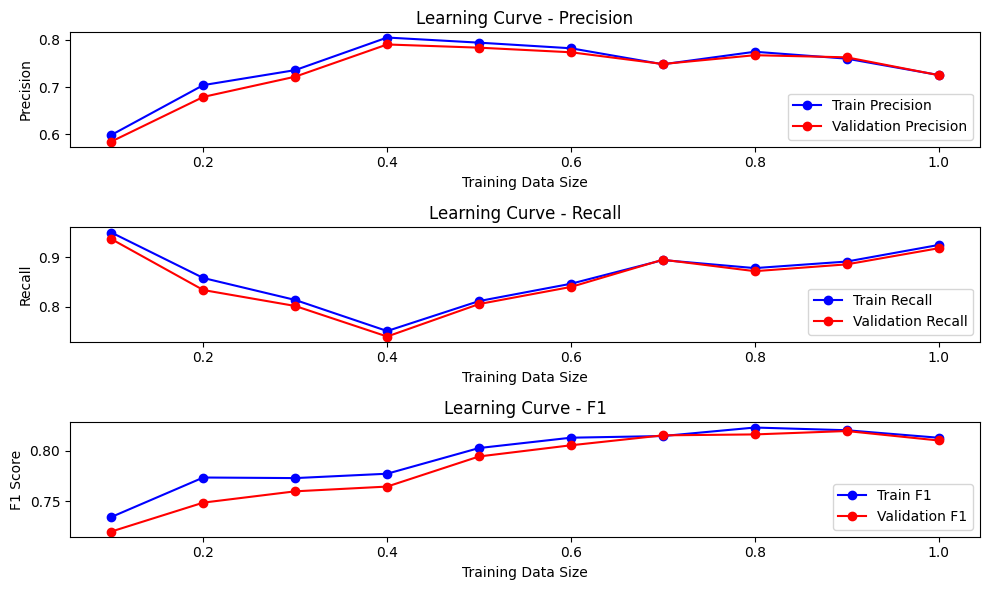

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.87      0.65      0.75     12500
           1       0.72      0.90      0.80     12500

    accuracy                           0.78     25000
   macro avg       0.80      0.78      0.78     25000
weighted avg       0.80      0.78      0.78     25000


Precision, Recall, F1 for each class (Test Data):
Class 0: Precision: 0.87, Recall: 0.65, F1: 0.75
Class 1: Precision: 0.72, Recall: 0.90, F1: 0.80

Micro-Averaged Precision: 0.78
Micro-Averaged Recall: 0.78
Micro-Averaged F1: 0.78
Macro-Averaged Precision: 0.80
Macro-Averaged Recall: 0.78
Macro-Averaged F1: 0.78


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Helper function for plotting
def plot_learning_curve(train_sizes, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1):
    plt.figure(figsize=(10, 6))
    
    # Plot Precision
    plt.subplot(3, 1, 1)
    plt.plot(train_sizes, train_precision, label='Train Precision', color='blue', marker='o')
    plt.plot(train_sizes, val_precision, label='Validation Precision', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - Precision')
    
    # Plot Recall
    plt.subplot(3, 1, 2)
    plt.plot(train_sizes, train_recall, label='Train Recall', color='blue', marker='o')
    plt.plot(train_sizes, val_recall, label='Validation Recall', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - Recall')
    
    # Plot F1
    plt.subplot(3, 1, 3)
    plt.plot(train_sizes, train_f1, label='Train F1', color='blue', marker='o')
    plt.plot(train_sizes, val_f1, label='Validation F1', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - F1')
    
    plt.tight_layout()
    plt.show()

# Function for calculating precision, recall, and F1 score for learning curves
def calculate_metrics_for_curve(model, X_train, y_train, X_val, y_val):
    # Make predictions for training data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    return train_precision, train_recall, train_f1, val_precision, val_recall, val_f1

# Initialize model
rf_classifier = RandomForest()

# Initialize arrays to store metrics
train_sizes = np.linspace(0.1, 1.0, 10)  # Vary training size from 10% to 100%
train_precision, train_recall, train_f1 = [], [], []
val_precision, val_recall, val_f1 = [], [], []

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(x_train_binary_final, y_train, test_size=0.2, random_state=42)

# For each size of training data, fit the model and calculate metrics
for size in train_sizes:
    # Use a subset of the training data
    subset_X_train = X_train_split[:int(size * len(X_train_split))]
    subset_y_train = y_train_split[:int(size * len(y_train_split))]
    
    rf_classifier.fit(subset_X_train, subset_y_train)
    
    # Calculate precision, recall, and F1 for both train and validation sets
    metrics = calculate_metrics_for_curve(rf_classifier, subset_X_train, subset_y_train, X_val_split, y_val_split)
    
    train_precision.append(metrics[0])
    train_recall.append(metrics[1])
    train_f1.append(metrics[2])
    
    val_precision.append(metrics[3])
    val_recall.append(metrics[4])
    val_f1.append(metrics[5])

# Plot learning curves
plot_learning_curve(train_sizes, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1)

# Train on full training data
rf_classifier.fit(x_train_binary_final, y_train)

# Predict on test data
y_test_pred = rf_classifier.predict(x_test_binary_final)

# Print classification report for each class
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Calculate and print precision, recall, F1 for each class and averages
test_precision = precision_score(y_test, y_test_pred, average=None)
test_recall = recall_score(y_test, y_test_pred, average=None)
test_f1 = f1_score(y_test, y_test_pred, average=None)

# Display results in a tabular format
print("\nPrecision, Recall, F1 for each class (Test Data):")
for i, label in enumerate(np.unique(y_test)):
    print(f"Class {label}: Precision: {test_precision[i]:.2f}, Recall: {test_recall[i]:.2f}, F1: {test_f1[i]:.2f}")

# Display micro and macro averages
print(f"\nMicro-Averaged Precision: {precision_score(y_test, y_test_pred, average='micro'):.2f}")
print(f"Micro-Averaged Recall: {recall_score(y_test, y_test_pred, average='micro'):.2f}")
print(f"Micro-Averaged F1: {f1_score(y_test, y_test_pred, average='micro'):.2f}")

print(f"Macro-Averaged Precision: {precision_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"Macro-Averaged Recall: {recall_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"Macro-Averaged F1: {f1_score(y_test, y_test_pred, average='macro'):.2f}")

### MEROS B

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_sklearn = RandomForestClassifier(n_estimators=10,max_features='sqrt')
rf_sklearn.fit(x_train_binary_final,y_train)

y_pred_sklearn = rf_sklearn.predict(x_test_binary_final)

accuracy_sklearn = np.mean(y_pred_sklearn == y_test)
print(f"Scikit-learn Random Forest Accuracy: {accuracy_sklearn:.2f}")

Scikit-learn Random Forest Accuracy: 0.79


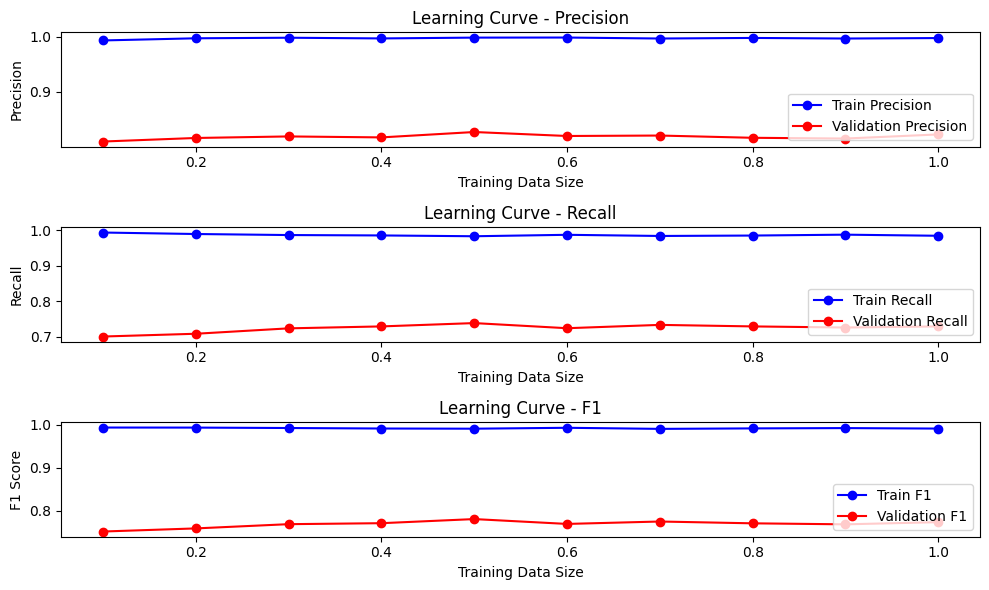

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     12500
           1       0.82      0.73      0.77     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000


Precision, Recall, F1 for each class (Test Data):
Class 0: Precision: 0.76, Recall: 0.84, F1: 0.80
Class 1: Precision: 0.82, Recall: 0.73, F1: 0.77

Micro-Averaged Precision: 0.79
Micro-Averaged Recall: 0.79
Micro-Averaged F1: 0.79
Macro-Averaged Precision: 0.79
Macro-Averaged Recall: 0.79
Macro-Averaged F1: 0.79


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Helper function for plotting
def plot_learning_curve(train_sizes, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1):
    plt.figure(figsize=(10, 6))
    
    # Plot Precision
    plt.subplot(3, 1, 1)
    plt.plot(train_sizes, train_precision, label='Train Precision', color='blue', marker='o')
    plt.plot(train_sizes, val_precision, label='Validation Precision', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - Precision')
    
    # Plot Recall
    plt.subplot(3, 1, 2)
    plt.plot(train_sizes, train_recall, label='Train Recall', color='blue', marker='o')
    plt.plot(train_sizes, val_recall, label='Validation Recall', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - Recall')
    
    # Plot F1
    plt.subplot(3, 1, 3)
    plt.plot(train_sizes, train_f1, label='Train F1', color='blue', marker='o')
    plt.plot(train_sizes, val_f1, label='Validation F1', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - F1')
    
    plt.tight_layout()
    plt.show()

# Function for calculating precision, recall, and F1 score for learning curves
def calculate_metrics_for_curve(model, X_train, y_train, X_val, y_val):
    # Make predictions for training data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    return train_precision, train_recall, train_f1, val_precision, val_recall, val_f1

# Initialize mode
# Initialize arrays to store metrics
train_sizes = np.linspace(0.1, 1.0, 10)  # Vary training size from 10% to 100%
train_precision, train_recall, train_f1 = [], [], []
val_precision, val_recall, val_f1 = [], [], []

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(x_train_binary_final, y_train, test_size=0.2, random_state=42)

# For each size of training data, fit the model and calculate metrics
for size in train_sizes:
    # Use a subset of the training data
    subset_X_train = X_train_split[:int(size * len(X_train_split))]
    subset_y_train = y_train_split[:int(size * len(y_train_split))]
    
    rf_sklearn.fit(subset_X_train, subset_y_train)
    
    # Calculate precision, recall, and F1 for both train and validation sets
    metrics = calculate_metrics_for_curve(rf_sklearn, subset_X_train, subset_y_train, X_val_split, y_val_split)
    
    train_precision.append(metrics[0])
    train_recall.append(metrics[1])
    train_f1.append(metrics[2])
    
    val_precision.append(metrics[3])
    val_recall.append(metrics[4])
    val_f1.append(metrics[5])

# Plot learning curves
plot_learning_curve(train_sizes, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1)

# Train on full training data
rf_sklearn.fit(x_train_binary_final, y_train)

# Predict on test data
y_test_pred = rf_sklearn.predict(x_test_binary_final)

# Print classification report for each class
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Calculate and print precision, recall, F1 for each class and averages
test_precision = precision_score(y_test, y_test_pred, average=None)
test_recall = recall_score(y_test, y_test_pred, average=None)
test_f1 = f1_score(y_test, y_test_pred, average=None)

# Display results in a tabular format
print("\nPrecision, Recall, F1 for each class (Test Data):")
for i, label in enumerate(np.unique(y_test)):
    print(f"Class {label}: Precision: {test_precision[i]:.2f}, Recall: {test_recall[i]:.2f}, F1: {test_f1[i]:.2f}")

# Display micro and macro averages
print(f"\nMicro-Averaged Precision: {precision_score(y_test, y_test_pred, average='micro'):.2f}")
print(f"Micro-Averaged Recall: {recall_score(y_test, y_test_pred, average='micro'):.2f}")
print(f"Micro-Averaged F1: {f1_score(y_test, y_test_pred, average='micro'):.2f}")

print(f"Macro-Averaged Precision: {precision_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"Macro-Averaged Recall: {recall_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"Macro-Averaged F1: {f1_score(y_test, y_test_pred, average='macro'):.2f}")